# AutoTSAD Evaluation Notebook 

## 1. Loading

### Load Accuracy Table

In [18]:
import pandas as pd
df_acc = pd.read_csv('../accuracy_table/VUS_PR.csv')
df_acc

### Statistical Test

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman
import networkx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import seaborn as sns

def Friedman_Nemenyi(alpha=0.05, df_perf=None):
    df_counts = pd.DataFrame({'count': df_perf.groupby(
        ['classifier_name']).size()}).reset_index()
    # Record the maximum number of datasets
    max_nb_datasets = df_counts['count'].max()
    # Create a list of classifiers
    classifiers = list(df_counts.loc[df_counts['count'] == max_nb_datasets]
                       ['classifier_name'])

    # print('classifiers: ', classifiers)

    '''
    Expected input format for friedmanchisquare is:
                Dataset1        Dataset2        Dataset3        Dataset4        Dataset5
    classifer1
    classifer2
    classifer3 
    '''

    # Compute friedman p-value
    friedman_p_value = friedmanchisquare(*(
        np.array(df_perf.loc[df_perf['classifier_name'] == c]['accuracy'])
        for c in classifiers))[1]

    # Decide whether to reject the null hypothesis
    # If p-value >= alpha: we cannot reject the null hypothesis. No statistical difference.
    if friedman_p_value >= alpha:
        return None,None,None
    # Friedman test OK
    # Prepare input for Nemenyi test
    data = []
    for c in classifiers:
        data.append(df_perf.loc[df_perf['classifier_name'] == c]['accuracy'])
    data = np.array(data, dtype=np.float64)
    # Conduct the Nemenyi post-hoc test
    # print(classifiers)
    # Order is classifiers' order
    nemenyi = posthoc_nemenyi_friedman(data.T)

    # print(nemenyi)
    
    # Original code: p_values.append((classifier_1, classifier_2, p_value, False)), True: represents there exists statistical difference
    p_values = []

    # Comparing p-values with the alpha value
    for nemenyi_indx in nemenyi.index:
        for nemenyi_columns in nemenyi.columns:
            if nemenyi_indx < nemenyi_columns:
                if nemenyi.loc[nemenyi_indx, nemenyi_columns] < alpha:
                    p_values.append((classifiers[nemenyi_indx], classifiers[nemenyi_columns], nemenyi.loc[nemenyi_indx, nemenyi_columns], True))
                else:
                    p_values.append((classifiers[nemenyi_indx], classifiers[nemenyi_columns], nemenyi.loc[nemenyi_indx, nemenyi_columns], False))
            else: continue

    # Nemenyi test OK

    m = len(classifiers)

    # Sort by classifier name then by dataset name
    sorted_df_perf = df_perf.loc[df_perf['classifier_name'].isin(classifiers)]. \
        sort_values(['classifier_name', 'dataset_name'])

    rank_data = np.array(sorted_df_perf['accuracy']).reshape(m, max_nb_datasets)

    df_ranks = pd.DataFrame(data=rank_data, index=np.sort(classifiers), columns=np.unique(sorted_df_perf['dataset_name']))

    dfff = df_ranks.rank(ascending=False)
    # compute average rank
    average_ranks = df_ranks.rank(ascending=False).mean(axis=1).sort_values(ascending=False)
    
    return p_values, average_ranks, max_nb_datasets

def graph_ranks(avranks, names, p_values, cd=None, cdmethod=None, lowv=None, highv=None,
                width=200, textspace=1, reverse=False, filename=None, **kwargs):
    
    width = width
    textspace = float(textspace)
    '''l is an array of array 
        [[......]
         [......]
         [......]]; 
    n is an integer'''
    # n th column
    def nth(l, n):
        n = lloc(l, n)
        # Return n th column
        return [a[n] for a in l]
    
    '''l is an array of array 
        [[......]
         [......]
         [......]]; 
    n is an integer'''
    # return an integer, count from front or from back.
    def lloc(l, n):
        if n < 0:
            return len(l[0]) + n
        else:
            return n
    # lr is an array of integers
    # Maximum range start from all zeros. Returns an iterable element of tuple.
    def mxrange(lr):
        # If nothing in the array
        if not len(lr):
            yield ()
        else:
            index = lr[0]
            # Check whether index is an integer.
            if isinstance(index, int):
                index = [index]
            # *index: index must be an iterable []
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    # Form a tuple, and generate an iterable value
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    nnames = names
    ssums = sums
    # lowv: low value
    if lowv is None:
        '''int(math.floor(min(ssums))): select the minimum value in ssums and take floor.
           Then compare with 1 to see which one is the minimum.'''
        lowv = min(1, int(math.floor(min(ssums))))
    # highv: high value
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4
    # how many algorithms
    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace
    
    # Position of rank
    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        # Set up the format
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # set up the formats
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant + 2

    # matplotlib figure format setup
    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_off()

    hf = 1. / height
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    # Line plots
    def line(l, color='k', **kwargs):
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    # Add text to the plot
    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05
    linewidth = 2.0
    linewidth_sign = 4.0

    tick = None

    # [lowv, highv], step size is 0.5
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        # If a is an integer
        if a == int(a):
            tick = bigtick
        # Plot a line
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=0.7)

    # Add text to the plot, only for integer value
    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", size=16)

    k = len(ssums)

    def filter_names(name):
        return name

    space_between_names = 0.24

    # Format for the first half of algorithms
    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=linewidth)
        if nnames[i] in ['Oracle', 'GB', 'SS', 'Random (TS)', 'Random (D)']:
            color = 'b'
        else:
            color = 'k'
        # text(textspace - 0.2, chei, filter_names(nnames[i]), color=color, ha="right", va="center", size=16)
        text(textspace - 0.2, chei, nnames[i], color=color, ha="right", va="center", size=16)



    # Format for the second half of algorithms
    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=linewidth)
        if nnames[i] in ['Oracle', 'GB', 'SS', 'Random (TS)', 'Random (D)']:
            color = 'b'
        else:
            color = 'k'
        # text(textspace + scalewidth + 0.2, chei, filter_names(nnames[i]), color=color, ha="left", va="center", size=16)
        text(textspace + scalewidth + 0.2, chei, nnames[i], color=color, ha="left", va="center", size=16)
        
    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line([(rankpos(ssums[l]) - side, start),
                  (rankpos(ssums[r]) + side, start)],
                 linewidth=linewidth_sign)
            start += height
            
    start = cline + 0.2
    side = -0.02
    height = 0.1

    #Generate cliques and plot a line to connect elements in cliques    
    cliques = form_cliques(p_values, nnames)
    i = 1
    achieved_half = False
    # Plot a line to connect elements in cliques
    for clq in cliques:
        if len(clq) == 1:
            continue
        min_idx = np.array(clq).min()
        max_idx = np.array(clq).max()
        if min_idx >= len(nnames) / 2 and achieved_half == False:
            start = cline + 0.25
            achieved_half = True
        line([(rankpos(ssums[min_idx]) - side, start),
              (rankpos(ssums[max_idx]) + side, start)],
             linewidth=linewidth_sign)
        start += height

def form_cliques(p_values, nnames):
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        if p[3] == False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1
    g = networkx.Graph(g_data)
    return networkx.find_cliques(g)

## 2. Gloal Ranking

### 2.1 Entire Benchmark

{'Oracle': 1, 'OE (AOM)': 2, 'CLF (ID)': 3, 'UReg (ID)': 4, 'UG (ID)': 5, 'CFact (ID)': 6, 'SS': 7, 'kNN (ID)': 8, 'OE (Max)': 9, 'OE (Avg)': 10, 'UReg (OOD)': 11, 'UG (OOD)': 12, 'CLF (OOD)': 13, 'GB': 14, 'kNN (OOD)': 15, 'Aug (Ens)': 16, 'HITS': 17, 'Synthetic (sim. cutoff)': 18, 'CQ (XB)': 19, 'Clean (Majority)': 20, 'CQ (Silhouette)': 21, 'Synthetic (sim. speeedup)': 22, 'Random (TS)': 23, 'CFact (OOD)': 24, 'Synthetic (sim. scale)': 25, 'CQ (DB)': 26, 'Synthetic (sim. contextual)': 27, 'Metaod (ID)': 28, 'ISAC (ID)': 29, 'Synthetic (orig. speeedup)': 30, 'Synthetic (orig. cutoff)': 31, 'Clean (Ratio)': 32, 'MC (5N)': 33, 'Synthetic (orig. contextual)': 34, 'ISAC (OOD)': 35, 'RA (Borda)': 36, 'Clean (Avg)': 37, 'RA (Trimmed Kemeny)': 38, 'CQ (Dunn)': 39, 'Random (D)': 40, 'Synthetic (orig. scale)': 41, 'RA (Trimmed Borda)': 42, 'MC (1N)': 43, 'Aug (Majority Voting)': 44, 'MC (3N)': 45, 'Aug (Orig)': 46, 'Synthetic (orig. noise)': 47, 'RA (Partial Borda)': 48, 'Clean (Individual)':

/tmp/ipykernel_2811691/2908650888.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


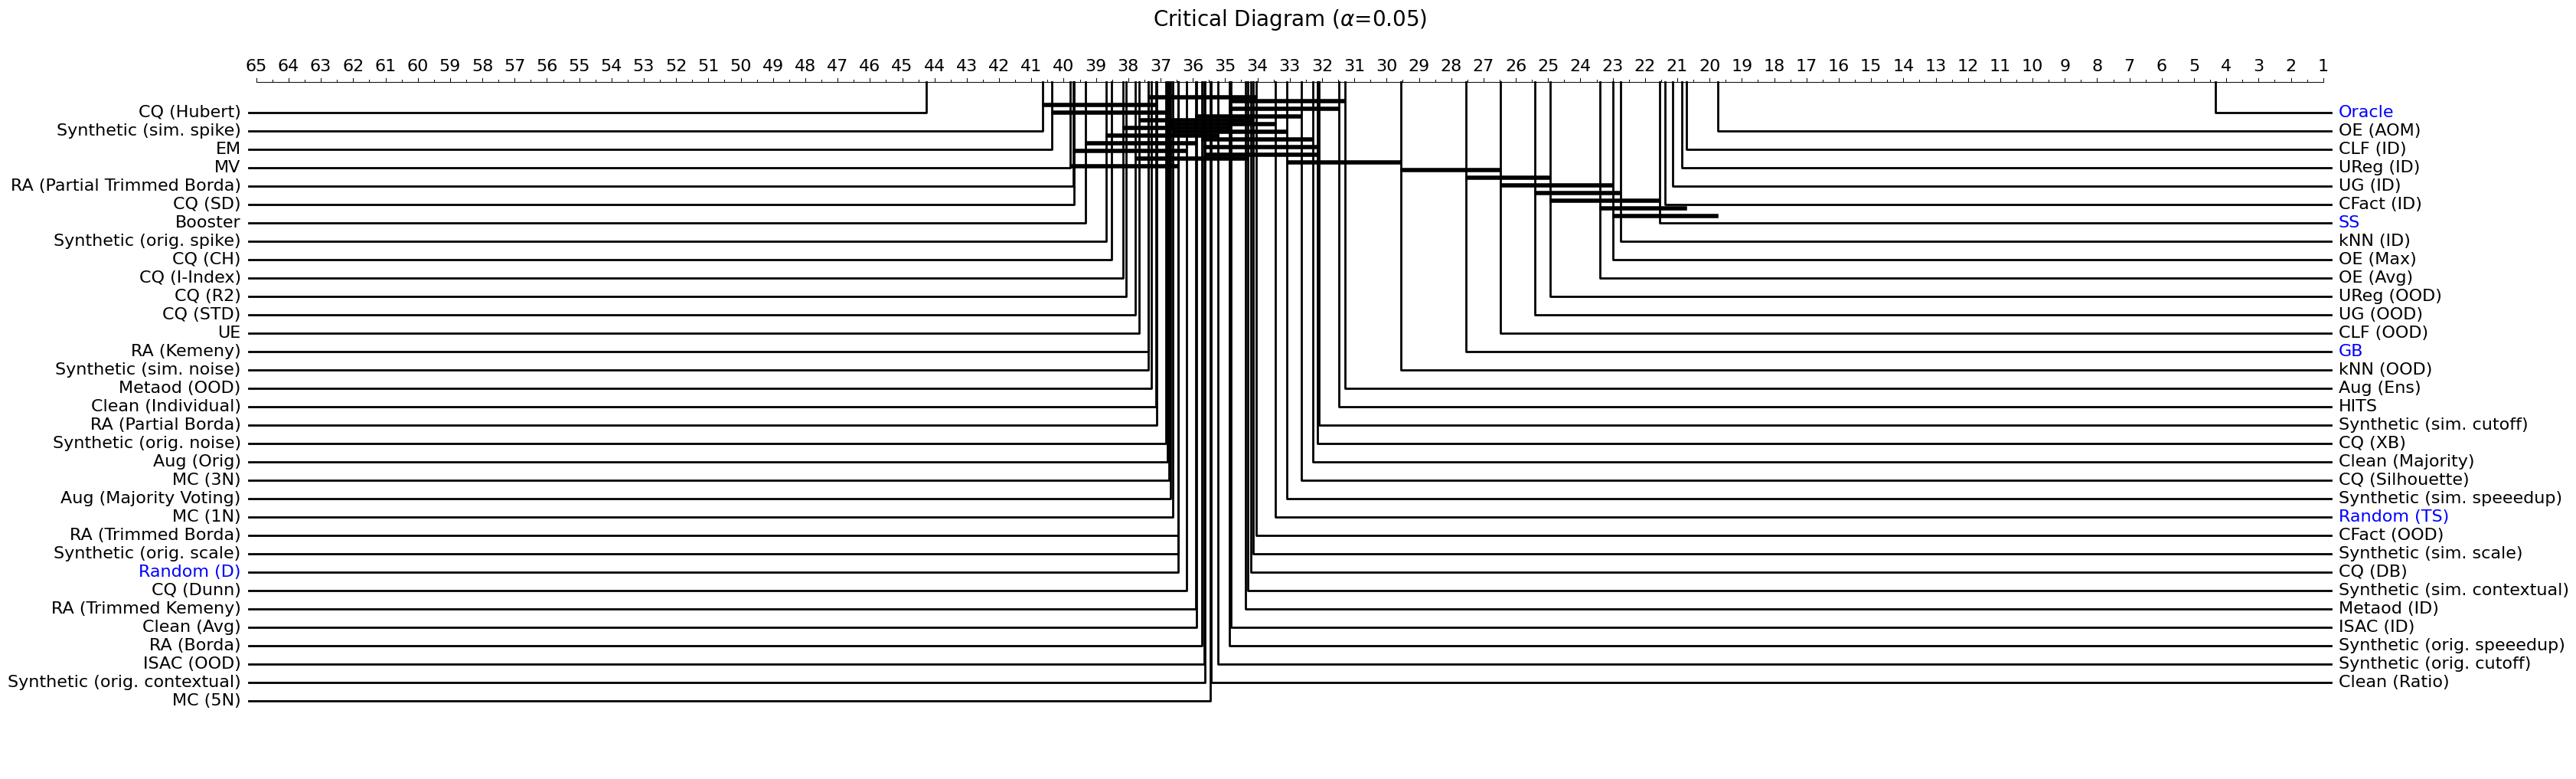

In [27]:
Comparaed_Solution_Pool = ['Oracle', 'GB', 'SS', 'Random (D)', 'Random (TS)',
       'OE (Avg)', 'OE (Max)', 'OE (AOM)', 'UE', 'Booster', 'HITS',
       'Aug (Majority Voting)', 'Aug (Orig)', 'Aug (Ens)',
       'Clean (Majority)', 'Clean (Ratio)', 'Clean (Avg)',
       'Clean (Individual)', 'EM', 'MV', 'MC (1N)', 'MC (3N)', 'MC (5N)',
       'CQ (XB)', 'CQ (STD)', 'CQ (R2)', 'CQ (Hubert)', 'CQ (CH)',
       'CQ (Silhouette)', 'CQ (I-Index)', 'CQ (DB)', 'CQ (SD)',
       'CQ (Dunn)', 'Synthetic (sim. spike)', 'Synthetic (sim. scale)',
       'Synthetic (sim. noise)', 'Synthetic (sim. cutoff)',
       'Synthetic (sim. contextual)', 'Synthetic (sim. speeedup)',
       'Synthetic (orig. spike)', 'Synthetic (orig. scale)',
       'Synthetic (orig. noise)', 'Synthetic (orig. cutoff)',
       'Synthetic (orig. contextual)', 'Synthetic (orig. speeedup)',
       'RA (Borda)', 'RA (Partial Borda)', 'RA (Trimmed Borda)',
       'RA (Partial Trimmed Borda)', 'RA (Kemeny)', 'RA (Trimmed Kemeny)',
       'kNN (ID)', 'kNN (OOD)', 'ISAC (ID)', 'ISAC (OOD)', 'Metaod (ID)',
       'Metaod (OOD)', 'CLF (ID)', 'CLF (OOD)', 'UG (ID)', 'UG (OOD)',
       'UReg (ID)', 'UReg (OOD)', 'CFact (ID)', 'CFact (OOD)']
    
eval_list = []
for index, row in df_acc.iterrows():
    for method in Comparaed_Solution_Pool:
        eval_list.append([method, row['file'], row[method]])
eval_df = pd.DataFrame(eval_list, columns=['classifier_name', 'dataset_name', 'accuracy'])
p_values, average_ranks, _ = Friedman_Nemenyi(df_perf=eval_df, alpha=0.05)
graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
            cd=None, reverse=True, width=30, textspace=1.5)
list_to_dict = {item: index for index, item in enumerate(average_ranks.keys().to_list()[::-1], start=1)}
print(list_to_dict)
plt.title("Critical Diagram ({}=0.05)".format(r'$\alpha$'),fontsize=20)
plt.tight_layout()

### 2.2 Best Variant

{'Oracle': 1, 'UReg (ID)': 2, 'CLF (ID)': 3, 'OE (AOM)': 4, 'CFact (ID)': 5, 'UG (ID)': 6, 'SS': 7, 'kNN (ID)': 8, 'GB': 9, 'Aug (Ens)': 10, 'HITS': 11, 'Synthetic (sim. cutoff)': 12, 'CQ (XB)': 13, 'Metaod (ID)': 14, 'Random (TS)': 15, 'ISAC (ID)': 16, 'MC (5N)': 17, 'RA (Borda)': 18, 'Clean (Avg)': 19, 'UE': 20, 'Random (D)': 21, 'Booster': 22, 'EM': 23}


/tmp/ipykernel_2811691/3244328852.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


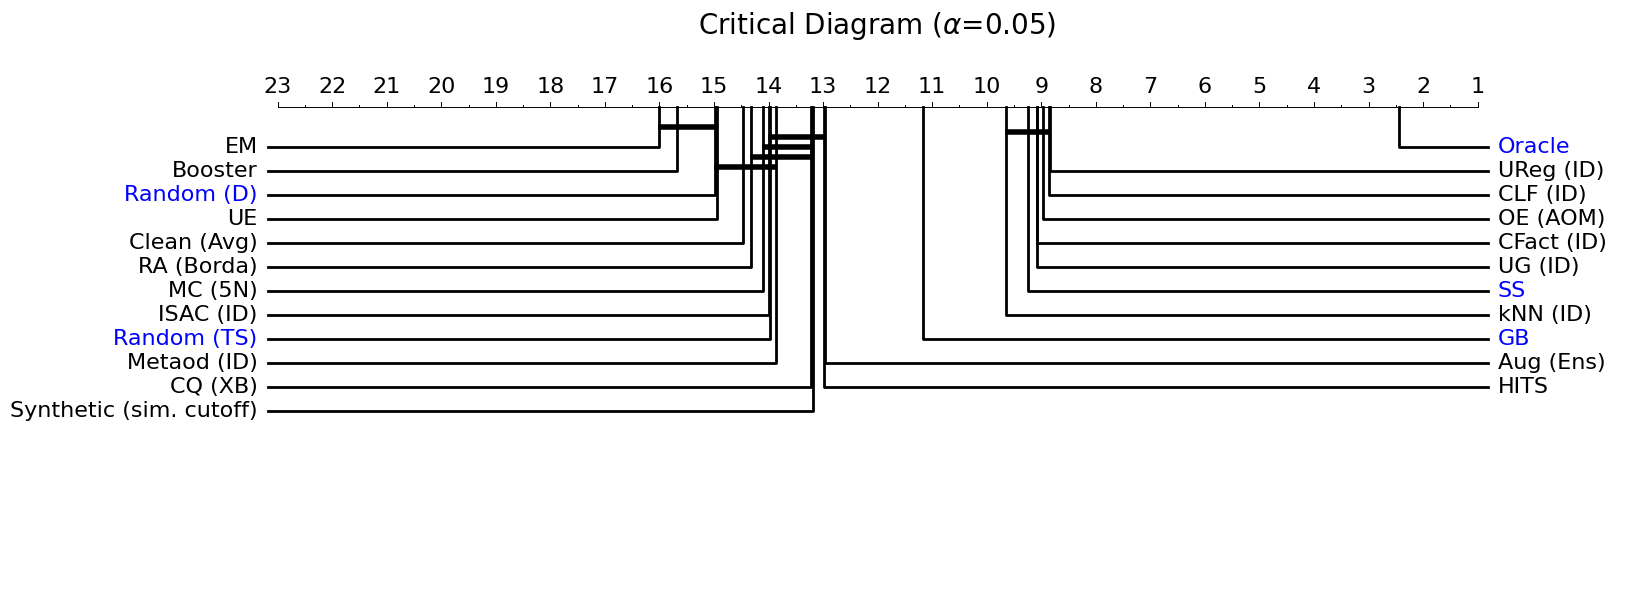

In [30]:
Comparaed_Solution_Pool = ['Oracle', 'GB', 'SS', 'Random (D)', 'Random (TS)',
       'OE (AOM)', 'UE', 'Booster', 'HITS', 'Aug (Ens)', 'Clean (Avg)', 'EM', 'MC (5N)', 'CQ (XB)', 'Synthetic (sim. cutoff)',
       'RA (Borda)', 'kNN (ID)', 'ISAC (ID)', 'Metaod (ID)', 'CLF (ID)', 'UG (ID)', 'UReg (ID)', 'CFact (ID)']
    
eval_list = []
for index, row in df_acc.iterrows():
    for method in Comparaed_Solution_Pool:
        eval_list.append([method, row['file'], row[method]])
eval_df = pd.DataFrame(eval_list, columns=['classifier_name', 'dataset_name', 'accuracy'])
p_values, average_ranks, _ = Friedman_Nemenyi(df_perf=eval_df, alpha=0.05)
graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
            cd=None, reverse=True, width=15, textspace=1.5)
list_to_dict = {item: index for index, item in enumerate(average_ranks.keys().to_list()[::-1], start=1)}
print(list_to_dict)
plt.title("Critical Diagram ({}=0.05)".format(r'$\alpha$'),fontsize=20)
plt.tight_layout()

## 3. Analysis on Anomaly Type

### 3.1 Point vs Sequence Anomaly

order_point: ['UReg (ID)', 'CFact (ID)', 'Synthetic (sim. cutoff)', 'OE (AOM)', 'CLF (ID)', 'ISAC (ID)', 'UG (ID)', 'HITS', 'Aug (Ens)', 'kNN (ID)', 'CQ (XB)', 'Clean (Avg)', 'EM', 'RA (Borda)', 'Booster', 'UE', 'Metaod (ID)', 'MC (5N)']


/tmp/ipykernel_2811691/2672751316.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


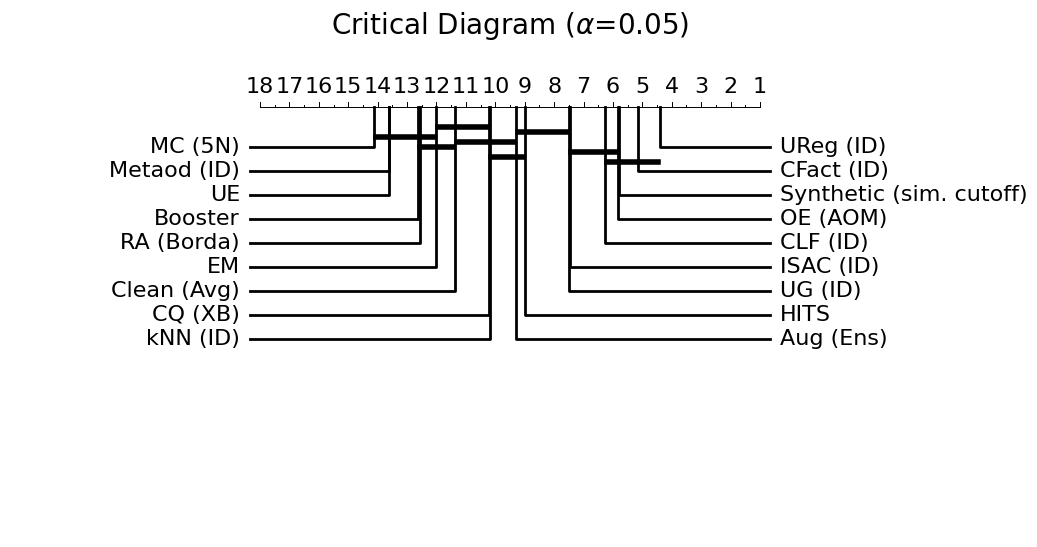

order_seq: ['CLF (ID)', 'UG (ID)', 'kNN (ID)', 'OE (AOM)', 'UReg (ID)', 'CFact (ID)', 'Aug (Ens)', 'HITS', 'CQ (XB)', 'Metaod (ID)', 'MC (5N)', 'Synthetic (sim. cutoff)', 'RA (Borda)', 'Clean (Avg)', 'UE', 'ISAC (ID)', 'Booster', 'EM']


/tmp/ipykernel_2811691/2672751316.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


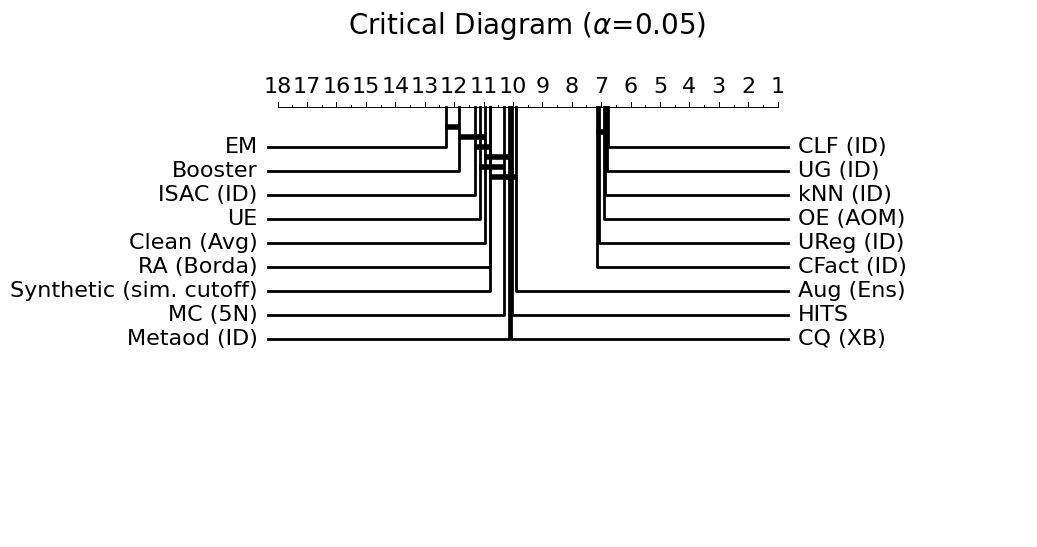

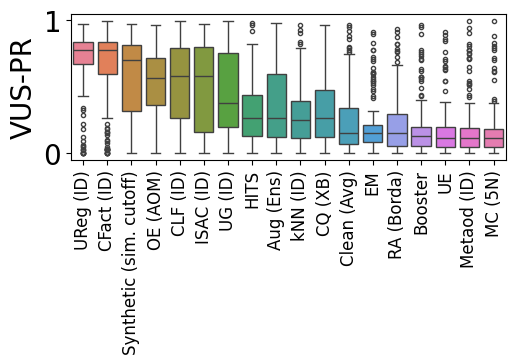

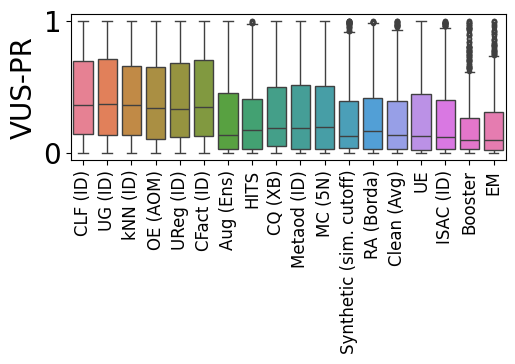

In [33]:
Comparaed_Solution_Pool = ['OE (AOM)', 'UE', 'Booster', 'HITS', 'Aug (Ens)', 'Clean (Avg)', 'EM', 'MC (5N)', 'CQ (XB)', 'Synthetic (sim. cutoff)',
       'RA (Borda)', 'kNN (ID)', 'ISAC (ID)', 'Metaod (ID)', 'CLF (ID)', 'UG (ID)', 'UReg (ID)', 'CFact (ID)']

df_filter = df_acc[df_acc['point_anomaly'] == 1]
eval_list = []
for index, row in df_filter.iterrows():
    for method in Comparaed_Solution_Pool:
        eval_list.append([method, row['file'], row[method]])
eval_df = pd.DataFrame(eval_list, columns=['classifier_name', 'dataset_name', 'accuracy'])
p_values, average_ranks, _ = Friedman_Nemenyi(df_perf=eval_df, alpha=0.05)
graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
            cd=None, reverse=True, width=10, textspace=2.5)
order_point = average_ranks.keys().to_list()[::-1]
print('order_point:', order_point)
plt.title("Critical Diagram ({}=0.05)".format(r'$\alpha$'),fontsize=20)
plt.tight_layout()
plt.show()

df_filter = df_acc[df_acc['seq_anomaly'] == 1]
eval_list = []
for index, row in df_filter.iterrows():
    for method in Comparaed_Solution_Pool:
        eval_list.append([method, row['file'], row[method]])
eval_df = pd.DataFrame(eval_list, columns=['classifier_name', 'dataset_name', 'accuracy'])
p_values, average_ranks, _ = Friedman_Nemenyi(df_perf=eval_df, alpha=0.05)
graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
            cd=None, reverse=True, width=10, textspace=2.5)
order_seq = average_ranks.keys().to_list()[::-1]
print('order_seq:', order_seq)
plt.title("Critical Diagram ({}=0.05)".format(r'$\alpha$'),fontsize=20)
plt.tight_layout()
plt.show()

### 
order_point_mappings = order_point
order_seq_mappings = order_seq
flierprops = dict(marker='o', markersize=3)
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(6,4))
ax = sns.boxplot(data=df_acc[df_acc['point_anomaly'] == 1][order_point], palette="husl", flierprops=flierprops)
plt.xticks(ticks=range(len(order_point_mappings)), labels=order_point_mappings, rotation=90, fontsize=12)
labels_to_change = ['Global Best', 'Random (TS)']
xticks = ax.get_xticklabels()
for label in xticks:
    if label.get_text() in labels_to_change:
        label.set_color('blue')
    else:
        label.set_color('black')
plt.ylabel('VUS-PR')
plt.tight_layout()

plt.figure(figsize=(6,4))
ax = sns.boxplot(data=df_acc[df_acc['seq_anomaly'] == 1][order_seq], palette="husl", flierprops=flierprops)
plt.xticks(ticks=range(len(order_seq_mappings)), labels=order_seq_mappings, rotation=90, fontsize=12)
labels_to_change = ['Global Best', 'Random (TS)']
xticks = ax.get_xticklabels()
for label in xticks:
    if label.get_text() in labels_to_change:
        label.set_color('blue')
    else:
        label.set_color('black')
plt.ylabel('VUS-PR')
plt.tight_layout()

### 3.2 Single vs Multiple Anomaly

order_point: ['OE (AOM)', 'UReg (ID)', 'CLF (ID)', 'UG (ID)', 'kNN (ID)', 'CFact (ID)', 'CQ (XB)', 'Synthetic (sim. cutoff)', 'HITS', 'Aug (Ens)', 'MC (5N)', 'Metaod (ID)', 'RA (Borda)', 'ISAC (ID)', 'UE', 'EM', 'Clean (Avg)', 'Booster']


/tmp/ipykernel_2811691/3811776338.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


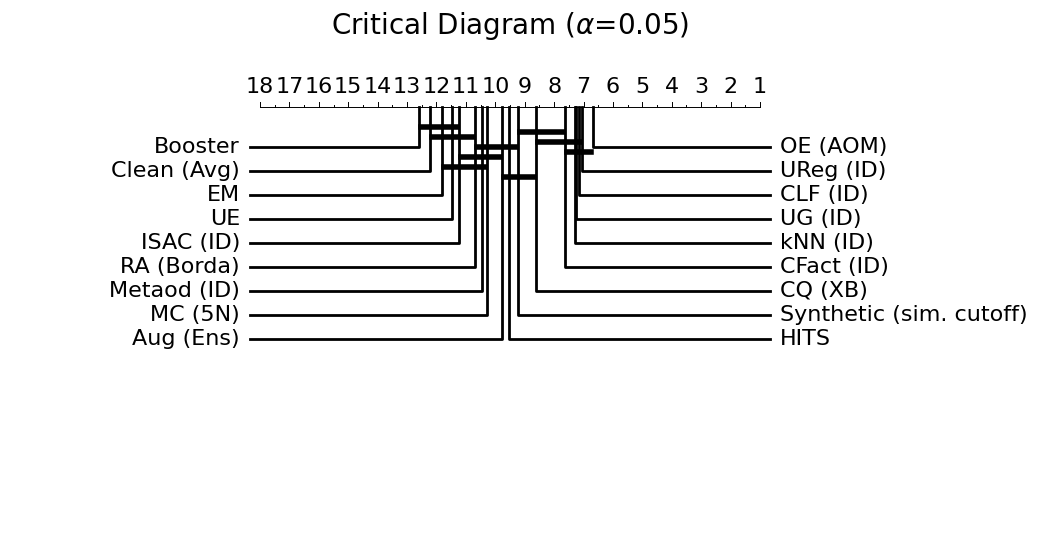

order_seq: ['CLF (ID)', 'UReg (ID)', 'CFact (ID)', 'UG (ID)', 'OE (AOM)', 'kNN (ID)', 'Aug (Ens)', 'HITS', 'Synthetic (sim. cutoff)', 'ISAC (ID)', 'Clean (Avg)', 'CQ (XB)', 'Metaod (ID)', 'MC (5N)', 'RA (Borda)', 'UE', 'Booster', 'EM']


/tmp/ipykernel_2811691/3811776338.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


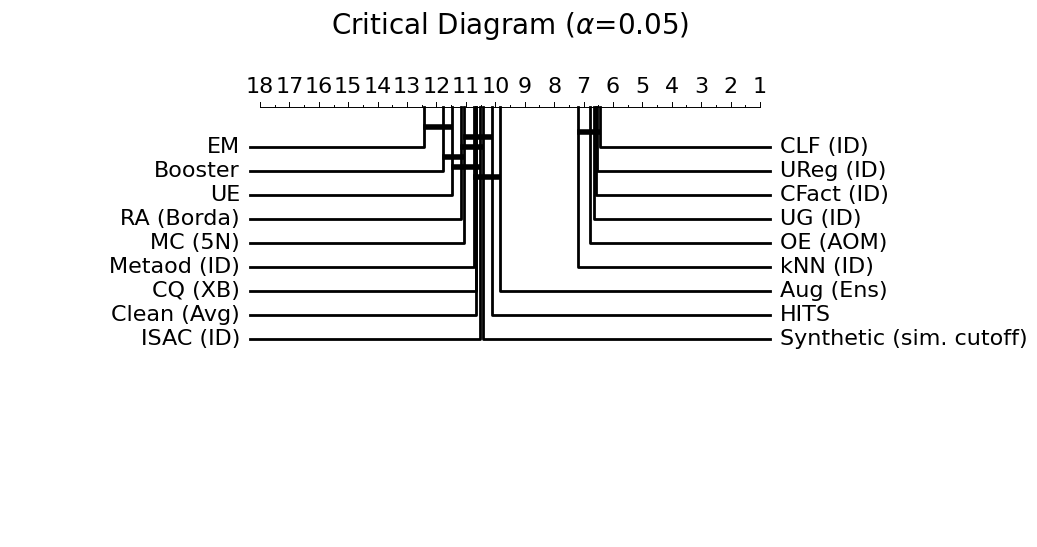

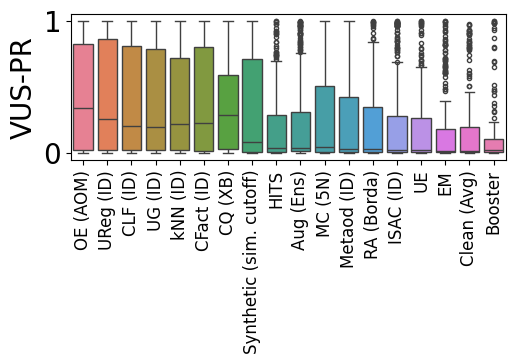

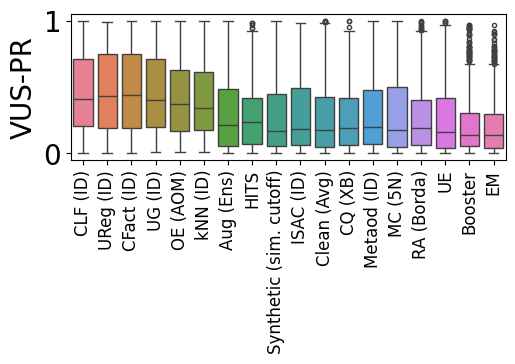

In [34]:
Comparaed_Solution_Pool = ['OE (AOM)', 'UE', 'Booster', 'HITS', 'Aug (Ens)', 'Clean (Avg)', 'EM', 'MC (5N)', 'CQ (XB)', 'Synthetic (sim. cutoff)',
       'RA (Borda)', 'kNN (ID)', 'ISAC (ID)', 'Metaod (ID)', 'CLF (ID)', 'UG (ID)', 'UReg (ID)', 'CFact (ID)']


df_filter = df_acc[df_acc['num_anomaly'] == 1]
eval_list = []
for index, row in df_filter.iterrows():
    for method in Comparaed_Solution_Pool:
        eval_list.append([method, row['file'], row[method]])
eval_df = pd.DataFrame(eval_list, columns=['classifier_name', 'dataset_name', 'accuracy'])
p_values, average_ranks, _ = Friedman_Nemenyi(df_perf=eval_df, alpha=0.05)
graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
            cd=None, reverse=True, width=10, textspace=2.5)
order_point = average_ranks.keys().to_list()[::-1]
print('order_point:', order_point)
plt.title("Critical Diagram ({}=0.05)".format(r'$\alpha$'),fontsize=20)
plt.tight_layout()
plt.show()

df_filter = df_acc[df_acc['num_anomaly'] > 1]
eval_list = []
for index, row in df_filter.iterrows():
    for method in Comparaed_Solution_Pool:
        eval_list.append([method, row['file'], row[method]])
eval_df = pd.DataFrame(eval_list, columns=['classifier_name', 'dataset_name', 'accuracy'])
p_values, average_ranks, _ = Friedman_Nemenyi(df_perf=eval_df, alpha=0.05)
graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
            cd=None, reverse=True, width=10, textspace=2.5)
order_seq = average_ranks.keys().to_list()[::-1]
print('order_seq:', order_seq)
plt.title("Critical Diagram ({}=0.05)".format(r'$\alpha$'),fontsize=20)
plt.tight_layout()
plt.show()

### 
order_point_mappings = order_point
order_seq_mappings = order_seq
flierprops = dict(marker='o', markersize=3)
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(6,4))
ax = sns.boxplot(data=df_acc[df_acc['num_anomaly'] == 1][order_point], palette="husl", flierprops=flierprops)
plt.xticks(ticks=range(len(order_point_mappings)), labels=order_point_mappings, rotation=90, fontsize=12)
labels_to_change = ['Global Best', 'Random (TS)']
xticks = ax.get_xticklabels()
for label in xticks:
    if label.get_text() in labels_to_change:
        label.set_color('blue')
    else:
        label.set_color('black')
plt.ylabel('VUS-PR')
plt.tight_layout()

plt.figure(figsize=(6,4))
ax = sns.boxplot(data=df_acc[df_acc['num_anomaly'] > 1][order_seq], palette="husl", flierprops=flierprops)
plt.xticks(ticks=range(len(order_seq_mappings)), labels=order_seq_mappings, rotation=90, fontsize=12)
labels_to_change = ['Global Best', 'Random (TS)']
xticks = ax.get_xticklabels()
for label in xticks:
    if label.get_text() in labels_to_change:
        label.set_color('blue')
    else:
        label.set_color('black')
plt.ylabel('VUS-PR')
plt.tight_layout()

### 3.3 Anomaly Ratio

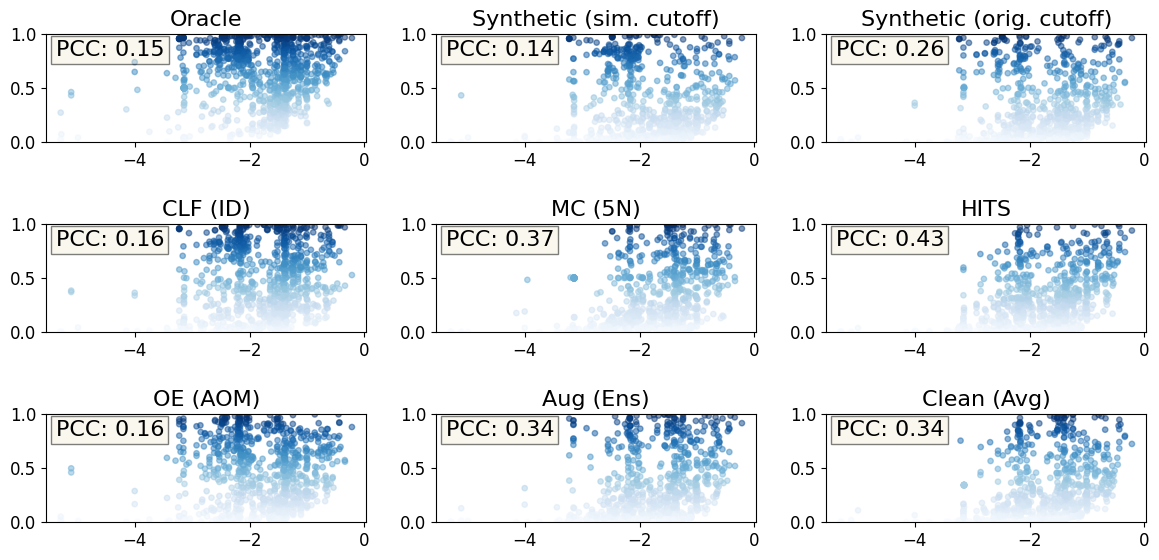

In [36]:
Comparaed_Solution_Pool=['Oracle', 'Synthetic (sim. cutoff)', 'Synthetic (orig. cutoff)',
                         'CLF (ID)', 'MC (5N)', 'HITS', 
                         'OE (AOM)', 'Aug (Ens)', 'Clean (Avg)']

plt.figure(figsize=(12, 6))
for id, method in enumerate(Comparaed_Solution_Pool):
    list1 = np.log10(df_acc['anomaly_ratio'])
    list2 = df_acc[f'{method}']

    # Calculate correlation
    plt.subplot(3, 3, id+1)
    correlation_coefficient = df_acc[f'{method}'].corr(df_acc['anomaly_ratio'])
    plt.scatter(list1, list2, alpha=0.5, s=15, edgecolors=None, c=list2, cmap='Blues')  # Transparency and smaller markers
    plt.ylim(0, 1)
    plt.xticks(fontsize=12)
    plt.yticks([0, 0.5, 1], fontsize=12)
    plt.text(0.03, 0.95, f'PCC: {correlation_coefficient:.2f}', fontsize=16, color='k', horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes,
             bbox={'facecolor': '#f4f1de', 'alpha': 0.5, 'pad': 3})
    plt.title(method, fontsize=16)

plt.tight_layout()